# Classification binaire : Chiens _vs._ Chats

Dans ce TP, on s'intéresse au problème simple (en apparence) de reconnaître des chiens et des chats dans des images.

<center><img src="img/catdogdataset.png" style="width:1000;height:550px;"></center>
<caption><center><b> Figure 1 : Quelques images de la base de données </b></center></caption>

Pour cela nous allons utiliser une base de données de 4000 images, réparties en 2000 images d'apprentissage, 1000 images de validation, et 1000 images de test. Compte-tenu de la variabilité possible des représentations de chiens et chats, cette base de données est d'une taille assez réduite et le problème est complexe. Il correspond bien aux problèmes que nous pouvons rencontrer dans la réalité, lorsque les données sont souvent difficiles à obtenir.


In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras

from tensorflow.keras import optimizers
from keras import layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Chargement des données  <a id='data_load'></a>

Les cellules suivantes permettent de charger les données dans un format adapté. Ne passez pas trop de temps dessus dans un premier temps, nous reviendrons dessus dans la partie "[validation croisée](#cv)".

In [2]:
!git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/cats-vs-dogs.git

fatal: destination path 'cats-vs-dogs' already exists and is not an empty directory.


In [3]:
import shutil

path = "./cats-vs-dogs/"

* Création de _listes_ contenant les noms des images des ensemble d'apprentissage, de validation et de test, ainsi que les label (0: chat, 1:chien) associés

In [4]:
#Images d'entrainement
train_filenames_dogs = os.listdir(path + "train/dogs")
train_filenames_cats = os.listdir(path + "train/cats")
if not os.path.exists(path + "train/train"):
    os.mkdir(path + "train/train")

path_train = path + "train/"
for filename in train_filenames_cats:
    shutil.copyfile(path_train+"cats/"+filename, path_train+"train/"+filename)
for filename in train_filenames_dogs:
    shutil.copyfile(path_train+"dogs/"+filename, path_train+"train/"+filename)

train_filenames = os.listdir(path + "train/train")
train_categories =[]
for filename in train_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        train_categories.append(1)
    else:
        train_categories.append(0)


#Images de validation
validation_filenames = os.listdir(path +"validation/")
validation_categories=[]
for filename in validation_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        validation_categories.append(1)
    else:
        validation_categories.append(0)


#Images de test
test_filenames = os.listdir(path + "test/")
test_categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        test_categories.append(1)
    else:
        test_categories.append(0)

* Création de _DataFrames_ pour permettre, plus loins, de charger les données au fur et à mesure des besoins.

In [5]:
#Images d'entrainement
train_df = pd.DataFrame({
    'filename': train_filenames,
    'category': train_categories
})


#Images de validation
validation_df = pd.DataFrame({
    'filename': validation_filenames,
    'category': validation_categories
})


#Images de test
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})


train_df['category'] = train_df['category'].astype(str)
validation_df['category'] = validation_df['category'].astype(str)
test_df['category'] = test_df['category'].astype(str)

##### <i style="color:purple">**Question** : Le jeu de données est-il équilibré ?</i>

In [ ]:
## A COMPLETER ##

In [6]:
# %load solutions/ratio.py

total_train = train_df.shape[0]
total_validate = validation_df.shape[0]
total_test = test_df.shape[0]

ratio_train = np.sum(train_categories)/total_train
ratio_validate = np.sum(validation_categories)/total_validate
ratio_test = np.sum(test_categories)/total_test

print("Ratio chien/chat - Train :", ratio_train)
print("Ratio chien/chat - Validation :", ratio_validate)
print("Ratio chien/chat - Test :", ratio_test)

Ratio chien/chat - Train : 0.5
Ratio chien/chat - Validation : 0.5
Ratio chien/chat - Test : 0.5


### Visualisation des images

In [6]:
import random
from tensorflow.keras.utils import load_img

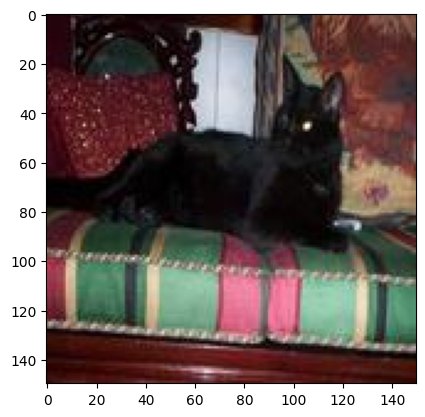

In [8]:
sample = random.choice(test_filenames)
image = load_img(path + "test/" + sample)

plt.imshow(image)
plt.show()

### Prétraitement des images

La syntaxe ci-dessous définit pour chaque ensemble de données des "generateurs" qui permettent de charger un nombre prédéfini d'images (ce sera notre taille de batch) à partir des _DataFrames_ définis précédemment.

On définit également une dimension cible des images (ici, 150x150) et un pré-traitement de normalisation (division par 255).

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
batch_size = 16
image_size = 150

#Images d'entrainement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path + "train/train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (image_size,image_size),
    class_mode = 'binary',
    batch_size = batch_size
)

#Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path + "validation/",
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size = batch_size
)

#Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path + "test/",
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size = batch_size
)

Found 2000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [9]:
labels= {0: 'Chat', 1: 'Chien'}
labels.get(0), labels.get(1)

('Chat', 'Chien')

##### <i style="color:purple">**Exercice** : Visualiser un échantillon d'images.</i>

Selectionner 9 images du jeu de données d'entraînement, et les afficher avec leur label respectif en guise de titre. Le code ci-dessous donne un exemple d'utilisation des générateurs définis précédement.

In [12]:
for X_batch, Y_batch in validation_generator:
    print(X_batch.shape)
    print(Y_batch.shape)
    print(Y_batch)
    break

(16, 150, 150, 3)
(16,)
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]


In [ ]:
## A COMPLETER ##
plt.figure(figsize=(12, 12))

[...]

plt.tight_layout()
plt.show()

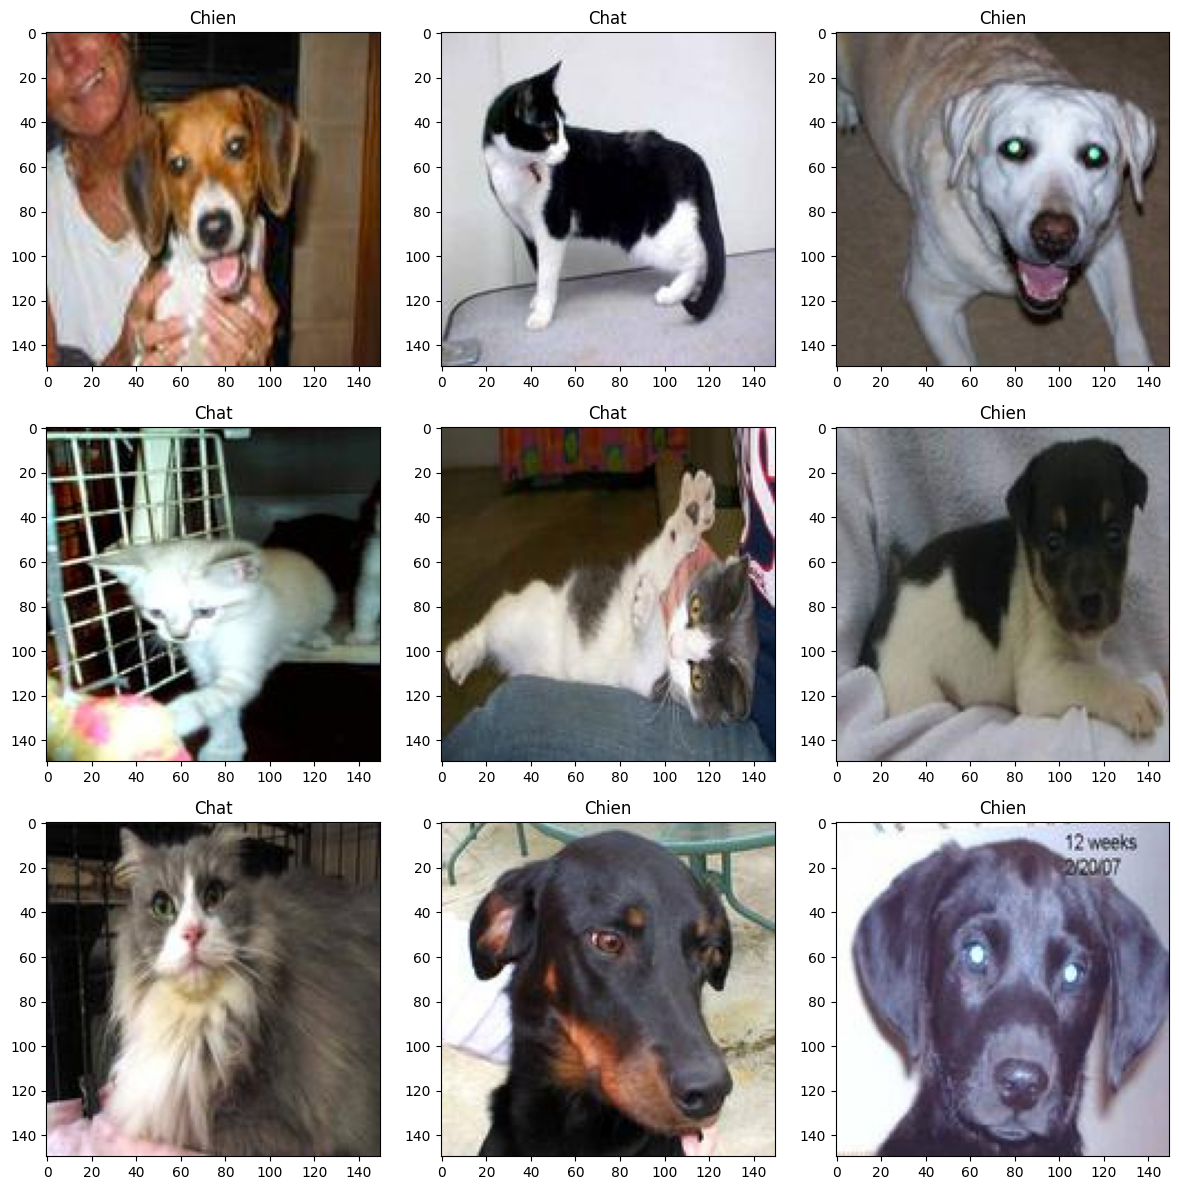

In [13]:
# %load solutions/data_visualization.py

plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.title(labels.get(Y_batch[0]))
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

## Première approche : réseau convolutif de base

Les images ont toutes été redimensionnées en $150\times150$. Nous pouvons donc définir notre réseau de neurones convolutif en suivant ce schéma :

<center> <img src="https://drive.google.com/uc?id=1bwXaIgO-pKJGs6fVaX0IrLbFbUAlTvNM" style="width:800;height:400px;"></center>
<caption><center><b> Figure 2: Vue de l'architecture à implémenter </b></center></caption>

Ce réseau alterne dans une première phase les couches de convolution et de Max Pooling (afin de diviser à chaque fois la dimension des tenseurs par 2).

* La première couche comptera 32 filtres de convolution, la seconde 64, la troisième 96 et la 4e 128.
* Enfin, avant la couche de sortie, vous ajouterez une couche dense comptant 512 neurones.

Vous aurez donc construit un réseau à 6 couches, sorte de version simplifiée d'AlexNet.

Pour construire ce réseau, vous pouvez utiliser les fonctions _Conv2D_, _Maxpooling2D_, et _Flatten_ de `Keras`.

In [ ]:
model = models.Sequential()

# A COMPLETER
# model.add(Conv2D(...))
# model.add(MaxPooling2D(..))
# ...
# model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
# ...

In [10]:
# %load solutions/CNN_model.py

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape=(image_size,image_size,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 96)       0


La commande ci-dessus doit rendre l'affichage suivant (aux noms des couches près) :

```
Model: "sequential"
___________________________________________________________________
 Layer (type)                  Output Shape                Param #   
===================================================================
 conv2d (Conv2D)                 (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D)    (None, 74, 74, 32)        0                                                                   
                                                                 
 conv2d_1 (Conv2D)               (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling2D)  (None, 36, 36, 64)        0                                                                   
                                                                 
 conv2d_2 (Conv2D)               (None, 34, 34, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 96)        0                                                                  
                                                                 
 conv2d_3 (Conv2D)               (None, 15, 15, 128)       110720    
                                                                 
 max_pooling2d_3 (MaxPooling2D)  (None, 7, 7, 128)         0                  
                                                                 
 flatten (Flatten)               (None, 6272)              0         
                                                                 
 dense (Dense)                   (None, 512)               3211776   
                                                                 
 dense_1 (Dense)                 (None, 1)                 513       
                                                                 
===================================================================
Total params: 3,397,793
Trainable params: 3,397,793
Non-trainable params: 0
_________________________________________________________________


```

_Remarque_ : La fonction plot_model permet de visualiser un réseau de neurones créé avec keras.



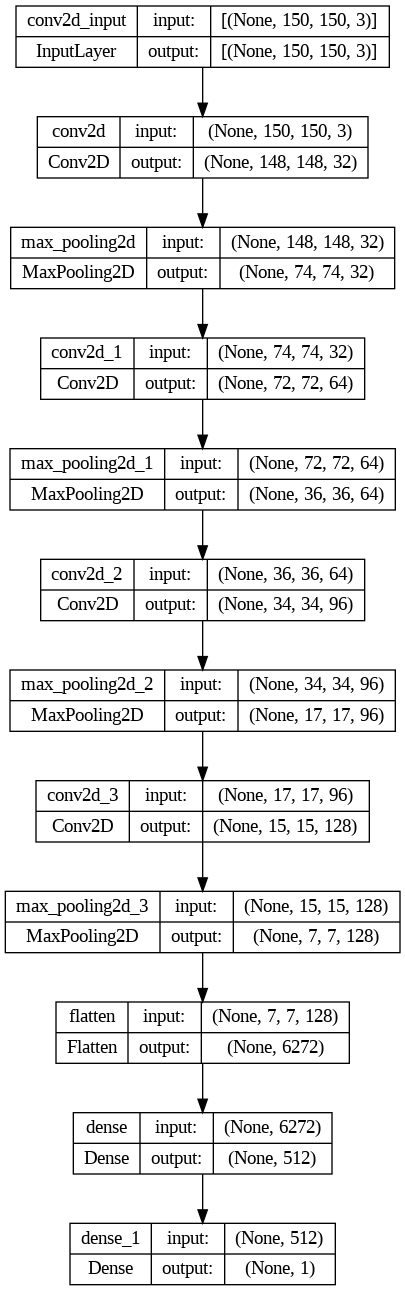

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

### Entrainement

Pour l'entraînement, vous pouvez utiliser directement les hyperparamètres suivants.

In [18]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

... puis lancer l'entraînement. **Attention : si jamais vous voulez relancer l'entraînement, il faut réinitialiser les poids du réseau. Pour cela il faut re-exécuter les cellules précédentes à partir de la définition du réseau !** Sinon vous risquez de repartir d'un entraînement précédent (qui s'est éventuellement bien, ou mal déroulé) et mal interpréter votre nouvel entraînement.

In [19]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=10)

Epoch 1/10
125/125 [==============================] - 9s 29ms/step - loss: 0.6940 - accuracy: 0.5180 - val_loss: 0.6863 - val_accuracy: 0.5840
Epoch 2/10
125/125 [==============================] - 4s 33ms/step - loss: 0.6607 - accuracy: 0.5995 - val_loss: 0.6353 - val_accuracy: 0.6600
Epoch 3/10
125/125 [==============================] - 3s 26ms/step - loss: 0.5833 - accuracy: 0.6900 - val_loss: 0.5995 - val_accuracy: 0.6930
Epoch 4/10
125/125 [==============================] - 3s 25ms/step - loss: 0.5166 - accuracy: 0.7390 - val_loss: 0.5603 - val_accuracy: 0.7160
Epoch 5/10
125/125 [==============================] - 3s 25ms/step - loss: 0.4701 - accuracy: 0.7690 - val_loss: 0.5790 - val_accuracy: 0.7130
Epoch 6/10
125/125 [==============================] - 5s 37ms/step - loss: 0.4006 - accuracy: 0.8230 - val_loss: 0.6228 - val_accuracy: 0.7240
Epoch 7/10
125/125 [==============================] - 3s 26ms/step - loss: 0.3458 - accuracy: 0.8510 - val_loss: 0.6108 - val_accuracy: 0.7150

### Analyse des résultats du modèle

##### <i style="color:purple">**Exercice** : Visualiser l'évolution des métriques au cours de l'entraînement.</i>

Ecire une fonction affichant l'évolution des métriques au cours de l'entraînement, sur les ensembles d'apprentissage et de validation. Afficher l'accuracy et la loss sur des figures distinctes.

In [ ]:
def plot_training_analysis():
    [...]

In [25]:
# %load solutions/plot_training_analysis.py

def plot_training_analysis():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

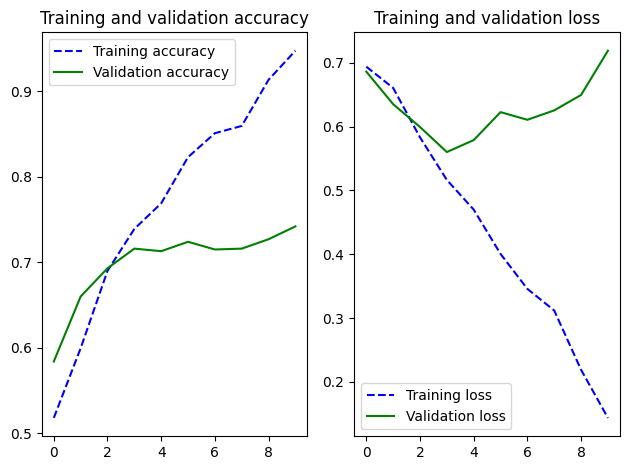

In [21]:
plot_training_analysis()

### Correction du surapprentissage <a id="data_augmented"></a>

Vous devriez maintenant reconnaître le problème auquel vous avez affaire : **le surapprentissage**. Ce problème est classique dès lors que l'on travaille sur des bases de données de taille réduite en apprentissage profond.
En effet, le réseau que vous avez créé compte normalement (si vous avez suivi les indications) plus de trois millions de paramètres. Le problème que vous essayez de résoudre pendant l'entraînement consiste à établir 3 millions de paramètres avec seulement 2000 exemples : c'est trop peu !

Afin de limiter ce surapprentissage, nous pouvons appliquer les techniques de régularisation vues pendant le 2nd cours. En traitement d'image, une des techniques les plus couramment utilisées est **l'augmentation de la base de données**.

Nous allons reprendre l'_ImageDataGenerator_ créé précédemment pour normaliser les images et l'utiliser  pour appliquer des transformations supplémentaires aux images de notre base de données. A vous de chercher dans la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) à quoi correspondent les différents paramètres présentés ci-dessous.

In [22]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path + 'train/train/',
    x_col ='filename',
    y_col ='category',
    target_size=(image_size,image_size),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


La cellule suivante vous permet de visualiser des images passées à travers notre boucle d'augmentation de données. Observez comment les valeurs manquantes sur les images (par exemple, dans le cas d'une rotation) sont comblées.

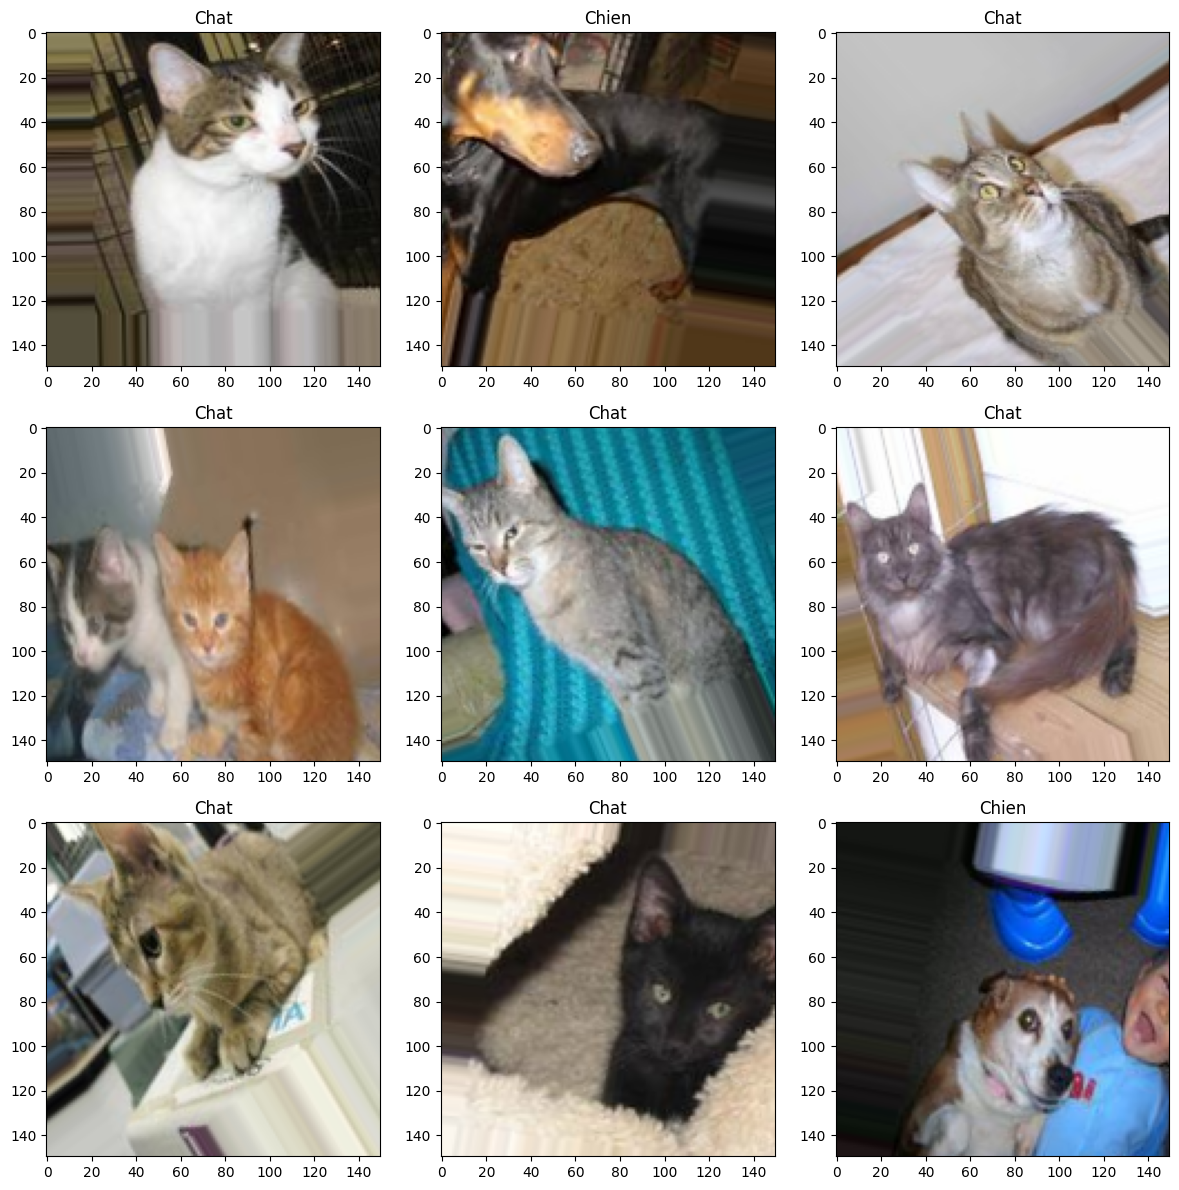

In [23]:
plt.figure(figsize=(12, 12))

example_x, example_y = train_generator_augmented.next()

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i])
    plt.title(labels.get(example_y[i]))

plt.tight_layout()
plt.show()

Nous pouvons maintenant recréer notre modèle et relancer l'entraînement.

In [ ]:
## A COMPLETER ##
model = models.Sequential()
[...]

model.summary()

## A COMPLETER ##
model.compile(...)

history = model.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = 50
)

In [24]:
# %load solutions/CNN_model.py

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape=(image_size,image_size,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [25]:
# %load solutions/CNN_train.py

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs=50
)

Epoch 1/50
125/125 [==============================] - 16s 112ms/step - loss: 0.6952 - accuracy: 0.5145 - val_loss: 0.6906 - val_accuracy: 0.5020
Epoch 2/50
125/125 [==============================] - 14s 112ms/step - loss: 0.6870 - accuracy: 0.5425 - val_loss: 0.6611 - val_accuracy: 0.5460
Epoch 3/50
125/125 [==============================] - 14s 112ms/step - loss: 0.6554 - accuracy: 0.5855 - val_loss: 0.6482 - val_accuracy: 0.6060
Epoch 4/50
125/125 [==============================] - 16s 127ms/step - loss: 0.6413 - accuracy: 0.6240 - val_loss: 0.7102 - val_accuracy: 0.5720
Epoch 5/50
125/125 [==============================] - 14s 111ms/step - loss: 0.6324 - accuracy: 0.6285 - val_loss: 0.6186 - val_accuracy: 0.6490
Epoch 6/50
125/125 [==============================] - 14s 114ms/step - loss: 0.5891 - accuracy: 0.6840 - val_loss: 0.6320 - val_accuracy: 0.6340
Epoch 7/50
125/125 [==============================] - 14s 113ms/step - loss: 0.6041 - accuracy: 0.6655 - val_loss: 0.6282 - val_ac

### Analyse des résultats

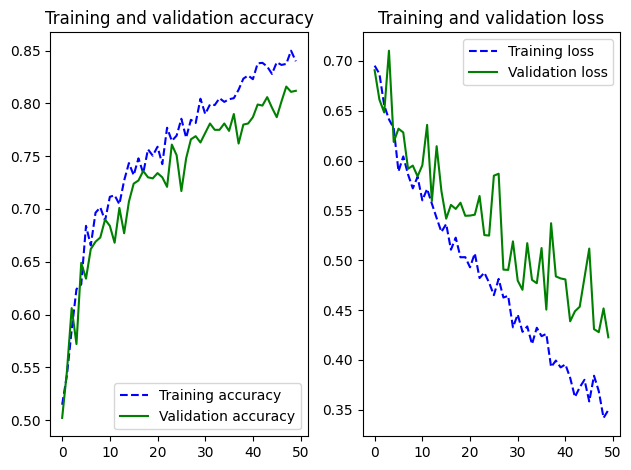

In [26]:
plot_training_analysis()

On voit clairement sur les courbes que l'on a limité le sur-apprentissage. Notez aussi d'ailleurs, et c'est important, que l'apprentissage est plus lent : le modèle met plus de temps à prédire correctement l'ensemble d'apprentissage. C'est normal, car on a en quelque sorte "complexifié le problème" en introduisant toutes ces déformations de nos images.
Cette forme de régularisation "par les données" s'ajoute aux autres méthodes que nous avons vues précédemment comme la régularisation L1/L2 des poids du réseau et le Dropout.  

Vous devriez maintenant atteindre des performances autour de 80% de précision sur l'ensemble de validation, ce qui est bien mais pas complètement satisfaisant : il faudrait pour continuer à s'améliorer probablement s'entraîner plus longtemps, mais également disposer de plus de données.

Une autre solution est d'utiliser le **Transfer Learning**.

## Transfer learning

L'une des raisons qui peut expliquer le fait que nos résultats soient décevants est que les premières couches de notre réseau convolutif, sensées détecter des caractéristiques utiles pour discriminer chiens et chats, n'ont pas appris de filtres suffisamment généraux à partir des 2000 images d'entraînement. Ainsi, même si ces filtres sont pertinents pour les 2000 images d'entraînement, il y a en fait assez peu de chances que ces filtres puissent bien fonctionner pour la généralisation sur de nouvelles données.

C'est la raison pour laquelle nous avons envie de réutiliser un réseau pré-entrainé sur une large base de données, permettant donc de détecter des caractéristiques qui généraliseront mieux à de nouvelles données.

Dans cette partie, nous allons réutiliser un réseau célèbre, et d'ores et déjà entraîné sur la base de données ImageNet : le réseau VGG-16.

Commençons par récupérer les couches de convolution de ce réseau, et s'en remémorer  la composition.

In [12]:
from tensorflow.keras.applications import VGG16

In [13]:
conv_base = VGG16(
    weights = 'imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
    include_top = False, # On ne conserve pas la partie Dense du réseau originel
    input_shape = (150, 150, 3)
)

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Nous pouvons extraire les caractéristiques, apprises par le réseau de neurones sur ImageNet, de notre base de données d'image de chiens et de chat. L'intérêt, par rapport à la première partie, est qu'il aurait été presque impossible de déduire ces caractéristiques "générales" (trouvées sur une immense base de données) depuis notre base de données trop réduite de 2000 images. En revanche, ces caractéristiques générales devraient se révéler utiles pour notre classifieur.

On peut lire sur la structure du réseau VGG résumée grâce à la fonction *summary* ci-dessus que le tenseur de sortie est de dimension $4 \times 4 \times 512$, autrement dit que le réseau prédit des caractéristiques de dimension $4 \times 4 \times 512$ à partir d'une image de taille $150 \times 150$.

On va redimensionner cette sortie dans un vecteur de dimension $8192 = 4 \times 4 \times 512$.

In [15]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0],4*4*512))

val_features = conv_base.predict(validation_generator)
val_features = np.reshape(val_features,(val_features.shape[0],4*4*512))

63/63 [==============================] - 4s 56ms/step


Il nous faut également récupérer les labels associés ; nous allons les chercher dans la dataframe définie au début du TP.

In [16]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,1]])

validation_data = validation_df.to_numpy()
y_val = np.array([int(numeric_string) for numeric_string in validation_data[:,1]])

Nous pouvons maintenant définir un réseau de neurones simple qui va travailler directement sur les caractéristiques prédites par VGG.

In [17]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5)) # On utilise du DropOut sur cette couche dense car elle comporte un grand nombre
                               # de paramètres et risque d'être très sujette au sur-apprentissage.
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=3e-4),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_features, y_train,
    epochs = 50,
    batch_size = 16,
    validation_data = (val_features, y_val)
)

Epoch 1/50
125/125 [==============================] - 2s 7ms/step - loss: 0.7803 - accuracy: 0.4950 - val_loss: 0.6999 - val_accuracy: 0.5030
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.6824 - accuracy: 0.5540 - val_loss: 0.7050 - val_accuracy: 0.4960
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.6646 - accuracy: 0.6015 - val_loss: 0.7267 - val_accuracy: 0.4930
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6210 - val_loss: 0.7137 - val_accuracy: 0.5140
Epoch 5/50
125/125 [==============================] - 1s 4ms/step - loss: 0.6114 - accuracy: 0.6585 - val_loss: 0.7566 - val_accuracy: 0.5060
Epoch 6/50
125/125 [==============================] - 1s 4ms/step - loss: 0.5848 - accuracy: 0.6915 - val_loss: 0.7475 - val_accuracy: 0.5060
Epoch 7/50
125/125 [==============================] - 1s 4ms/step - loss: 0.5589 - accuracy: 0.7125 - val_loss: 0.7571 - val_accuracy: 0.5110
Epoch 

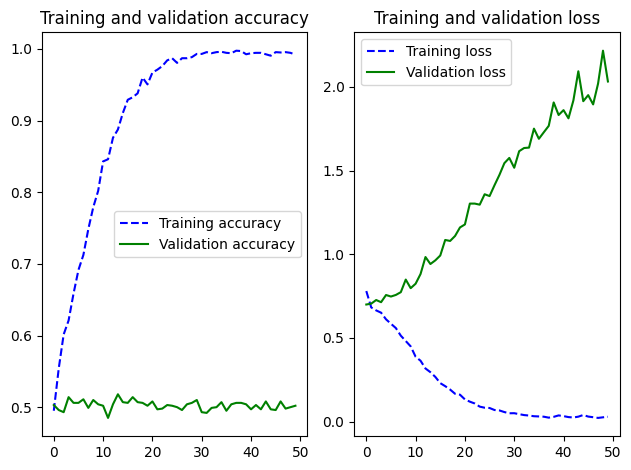

In [34]:
plot_training_analysis()

On observe à nouveau beaucoup de sur-apprentissage. Il faudrait trouver un moyen d'intégrer de l'augmentation de données.

Pour cela, on peut connecter notre petit réseau de neurones à l'extrémité de la base convolutionnelle de VGG. L'idée est qu'en réutilisant notre générateur de données augmentées, nous pourrons calculer les caractéristiques de VGG sur les données augmentées, et ainsi classifier ces caractéristiques plutôt que les caractéristiques de notre base de données uniquement.

## Transfer learning & Augmentation de données

### Définition du nouveau modèle et entrainement

On commence par créer un nouveau modèle qui va s'appuyer sur la base convolutive de VGG, à laquelle on adjoint une couche dense et notre couche de sortie.

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


**Attention** : il est important de ne pas commander l'entraînement de la base convolutionnelle de VGG ! Nous ne voulons en aucun cas écraser les bonnes caractéristiques de VGG que nous cherchons justement à réutiliser ! Le réseau aurait en outre un grand nombre de paramètres, ce qui est justement ce que l'on veut éviter !

Pour cela nous pouvons utiliser l'attribut *trainable* : en le positionnant à *false*, nous pouvons geler les poids et en empêcher la mise à jour pendant l'entraînement.

In [20]:
conv_base.trainable = False
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Observez le décompte des poids : le nombre de poids entraînable est maintenant à 2 millions, contre 16 millions précédemment ; on ne va entrainer ici que les poids de notre couche dense et de la couche de sortie.

In [23]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 50,
    validation_data = validation_generator
)

Epoch 1/50
125/125 [==============================] - 18s 134ms/step - loss: 0.4954 - accuracy: 0.7530 - val_loss: 0.2992 - val_accuracy: 0.8720
Epoch 2/50
125/125 [==============================] - 17s 138ms/step - loss: 0.3683 - accuracy: 0.8340 - val_loss: 0.2726 - val_accuracy: 0.8820
Epoch 3/50
125/125 [==============================] - 17s 134ms/step - loss: 0.3664 - accuracy: 0.8290 - val_loss: 0.3396 - val_accuracy: 0.8540
Epoch 4/50
125/125 [==============================] - 17s 133ms/step - loss: 0.3380 - accuracy: 0.8435 - val_loss: 0.2682 - val_accuracy: 0.8940
Epoch 5/50
125/125 [==============================] - 16s 131ms/step - loss: 0.3310 - accuracy: 0.8520 - val_loss: 0.2589 - val_accuracy: 0.8920
Epoch 6/50
125/125 [==============================] - 17s 132ms/step - loss: 0.3264 - accuracy: 0.8540 - val_loss: 0.2582 - val_accuracy: 0.8860
Epoch 7/50
125/125 [==============================] - 17s 136ms/step - loss: 0.3318 - accuracy: 0.8530 - val_loss: 0.2618 - val_ac

### Analyse des résultats du nouveau modèle

L'entraînement est beaucoup plus lent ! Il faut en effet générer les données augmentées, et leur faire traverser les couches de VGG à chaque itération de gradient. Ceci prend du temps !

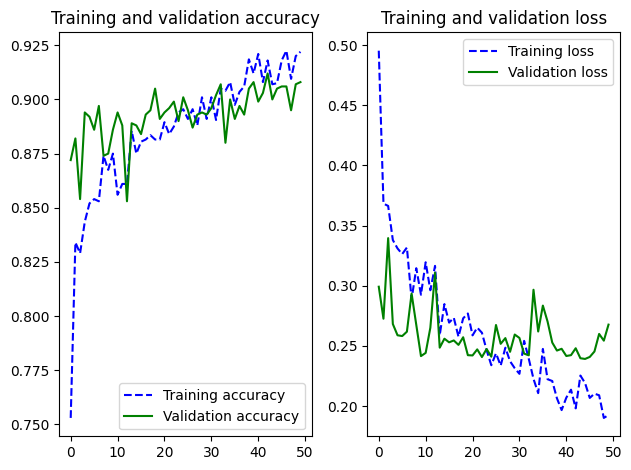

In [26]:
plot_training_analysis()

En revanche, on observe que l'on a bien limité le sur-apprentissage, ce qui était le but recherché. Cela améliore considérablement les résultats !

### Fine-tuning


Nous pouvons maintenant tester la dernière technique vue en cours : le **fine-tuning**. Pour cela, nous allons repartir du réseau que nous venons d'entraîner, mais nous allons débloquer l'entraînement des poids de l'ensemble du réseau. **ATTENTION : il est important de choisir un taux d'apprentissage très faible afin de ne pas réduire à néant les bénéfices des entraînements précédents.** L'objectif est simplement de faire évoluer les paramètres du réseau "à la marge", et ceci ne peut être fait qu'après la première étape de *transfer learning* précédente. Sans cela, les dernières couches ajoutées à la suite de la base convolutive, après leur initialisation aléatoire, auraient engendré de forts gradients qui auraient complètement détruit les filtres généraux de VGG.



On commence par réactiver l'entraînement des paramètres de la base convolutive de VGG :

In [27]:
conv_base.trainable = True
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 50,
    validation_data = validation_generator
)

Epoch 1/50
125/125 [==============================] - 28s 165ms/step - loss: 0.2075 - accuracy: 0.9155 - val_loss: 0.2364 - val_accuracy: 0.9200
Epoch 2/50
125/125 [==============================] - 19s 156ms/step - loss: 0.1930 - accuracy: 0.9195 - val_loss: 0.1828 - val_accuracy: 0.9280
Epoch 3/50
125/125 [==============================] - 21s 164ms/step - loss: 0.1325 - accuracy: 0.9465 - val_loss: 0.1589 - val_accuracy: 0.9370
Epoch 4/50
125/125 [==============================] - 20s 156ms/step - loss: 0.1254 - accuracy: 0.9495 - val_loss: 0.1712 - val_accuracy: 0.9480
Epoch 5/50
125/125 [==============================] - 20s 157ms/step - loss: 0.1188 - accuracy: 0.9485 - val_loss: 0.1718 - val_accuracy: 0.9400
Epoch 6/50
125/125 [==============================] - 21s 164ms/step - loss: 0.0938 - accuracy: 0.9630 - val_loss: 0.1377 - val_accuracy: 0.9540
Epoch 7/50
125/125 [==============================] - 20s 157ms/step - loss: 0.0990 - accuracy: 0.9595 - val_loss: 0.1519 - val_ac

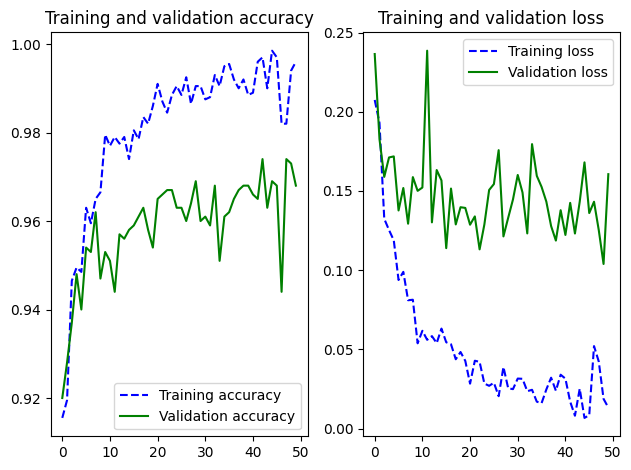

In [29]:
plot_training_analysis()

On atteint l'excellent résultat de 97% de précision sur l'ensemble de validation, bien au-dessus des performances obtenues sans *transfer learning* ! Vous comprenez maintenant pourquoi en traitement d'image, cette technique est incontournable.

## Global Average Pooling

En réalité, on utilise plus vraiment la couche _Flatten_ aujourd'hui pour faire le lien entre couches convolutives et couches denses, mais plutôt une couche de [GlobalAveragePooling](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/). Essayez de comprendre ce que fait cette couche et de modifier le réseau construit par dessus VGG en conséquence.

In [ ]:
## A COMPLETER ##

In [30]:
# %load solutions/GlobalAveragePooling_model.py
# Définition du modèle

conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3)
)

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


In [32]:
# %load solutions/GlobalAveragePooling_train.py
# Entraînement des dernières couches denses du réseau

conv_base.trainable = False

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 50,
    validation_data = validation_generator)

Epoch 1/50
125/125 [==============================] - 20s 134ms/step - loss: 0.3330 - accuracy: 0.8570 - val_loss: 0.2702 - val_accuracy: 0.8760
Epoch 2/50
125/125 [==============================] - 16s 128ms/step - loss: 0.3210 - accuracy: 0.8575 - val_loss: 0.2658 - val_accuracy: 0.8810
Epoch 3/50
125/125 [==============================] - 16s 130ms/step - loss: 0.3268 - accuracy: 0.8625 - val_loss: 0.2633 - val_accuracy: 0.8820
Epoch 4/50
125/125 [==============================] - 16s 130ms/step - loss: 0.3197 - accuracy: 0.8610 - val_loss: 0.2652 - val_accuracy: 0.8880
Epoch 5/50
125/125 [==============================] - 17s 135ms/step - loss: 0.3166 - accuracy: 0.8660 - val_loss: 0.2613 - val_accuracy: 0.8840
Epoch 6/50
125/125 [==============================] - 17s 132ms/step - loss: 0.3228 - accuracy: 0.8550 - val_loss: 0.2734 - val_accuracy: 0.8740
Epoch 7/50
125/125 [==============================] - 17s 136ms/step - loss: 0.3132 - accuracy: 0.8590 - val_loss: 0.2584 - val_ac

In [35]:
# %load solutions/GlobalAveragePooling_tune.py
# Passe finale de fine-tuning

conv_base.trainable = True

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 50,
    validation_data = validation_generator)

Epoch 1/50
125/125 [==============================] - 25s 166ms/step - loss: 0.0697 - accuracy: 0.9725 - val_loss: 0.1214 - val_accuracy: 0.9640
Epoch 2/50
125/125 [==============================] - 20s 160ms/step - loss: 0.0448 - accuracy: 0.9850 - val_loss: 0.1489 - val_accuracy: 0.9630
Epoch 3/50
125/125 [==============================] - 20s 156ms/step - loss: 0.0622 - accuracy: 0.9765 - val_loss: 0.1091 - val_accuracy: 0.9620
Epoch 4/50
125/125 [==============================] - 20s 163ms/step - loss: 0.0425 - accuracy: 0.9865 - val_loss: 0.1090 - val_accuracy: 0.9630
Epoch 5/50
125/125 [==============================] - 20s 156ms/step - loss: 0.0299 - accuracy: 0.9925 - val_loss: 0.1112 - val_accuracy: 0.9690
Epoch 6/50
125/125 [==============================] - 20s 159ms/step - loss: 0.0356 - accuracy: 0.9855 - val_loss: 0.1237 - val_accuracy: 0.9660
Epoch 7/50
125/125 [==============================] - 20s 160ms/step - loss: 0.0486 - accuracy: 0.9785 - val_loss: 0.1603 - val_ac

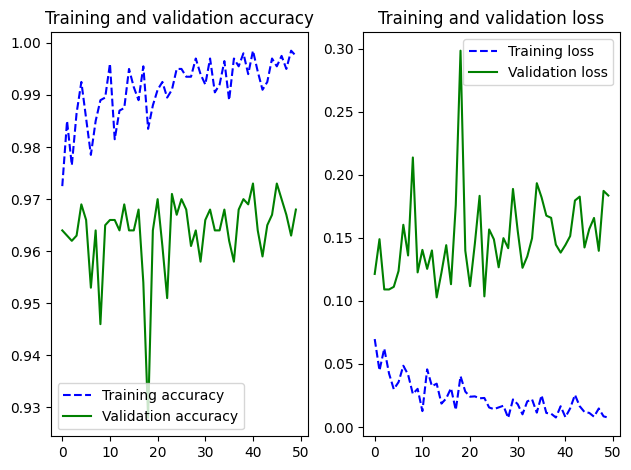

In [36]:
plot_training_analysis()

## Validation croisée <a id='cv'></a>

Afin de s'assurer que les performances précédentes ne dépendent pas de notre découpage ensemble d'entraînement/ensemble de validation, nous allons mettre en place une validation croisée. Nous devrions normalement obtenir des performances similaires pour chaque split.

In [37]:
from sklearn.model_selection import KFold

##### <i style="color:purple">**Exercice** : Preparer les données.</i>

En vous inspirant des blocs de la section "[chargement des données](#data_load)",
* Créez (s'il n'existe pas déjà) un dossier `cv` à la racine de `cats-vs-dogs`,
* Copiez l'ensemble des images d'entraînement et de validation dans ce dossier,
* Créez un _DataFrame_ `cv_df` rassemblant le nom des fichiers et leur label associé, pour l'ensemble des images contenues dans le dossier `cv`.

Les 5 premières lignes de `cv_df` devraient ressembler à :
```
       filename  category
0 	dog.775.jpg 	1
1 	cat.952.jpg 	0
2 	cat.946.jpg 	0
3 	dog.761.jpg 	1
4 	dog.991.jpg
```

In [ ]:
## A COMPLETER ##

[...]

categories = ...

[...]

cv_df = ...
cv_df.head()

In [38]:
# %load solutions/cv_load_data.py

if not os.path.exists(path + "cv"):
    os.mkdir(path + "cv")


categories = []

#Images d'entrainement
path_train = path + "train/train/"
train_filenames = os.listdir(path + "train/train")
for filename in train_filenames:
    shutil.copyfile(path_train+filename, path+"cv/"+filename)
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

#Images de validation
path_validation = path + "validation/"
validation_filenames = os.listdir(path + "validation")
for filename in validation_filenames:
    shutil.copyfile(path_validation+filename, path+"cv/"+filename)
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)


cv_df = pd.DataFrame({
    'filename': train_filenames+validation_filenames,
    'category': categories
})
cv_df['category'] = cv_df['category'].astype(str)
cv_df.head()

filename category
0  dog.245.jpg        1
1  dog.463.jpg        1
2  cat.274.jpg        0
3  dog.951.jpg        1
4  dog.649.jpg        1

##### <i style="color:purple">**Exercice** : Instancier un réseau de neurones.</i>

Ecrire une fonction `create_new_model` qui instancie un des réseaux au choix ci-dessus. À chaque nouveau split de la validation croisée, nous allons réaliser un appel à cette fonction.

Dans un premier temps, choisissez un réseau **simple** et pas trop long à entraîner pour pouvoir lancer plusieurs fois sans trop perdre de temps la validation croisée (utile en cas de bugs...).

In [ ]:
def create_new_model(image_size=150):
    [...]

In [39]:
# %load solutions/create_new_model.py

def create_new_model(image_size=150, choice='VGG16'):
    model = models.Sequential()

    if choice == 'CNN':
        model.add(Conv2D(32, (3,3), input_shape=(image_size,image_size,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(96, (3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(128, (3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

    elif choice == 'VGG16':
        conv_base = VGG16(
            weights = 'imagenet',
            include_top = False,
            input_shape = (150, 150, 3)
            )
        model.add(conv_base)
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        conv_base.trainable = False

    else:
        print("Network not implemented")

    return model

In [40]:
model = create_new_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


La fonction suivante permet d'obtenir le nom du modèle pour chacun des splits de la validation croisée.

In [41]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

Enfin, nous créons un dossier `saved_models` à la racine de `TP3` dans lequel nous allons stocker les poids des modèles obtenus pour chaque split.

In [42]:
if not os.path.exists("saved_models/"):
    os.mkdir("saved_models")

Nous pouvons à présent mettre en oeuvre la validation croisée.

##### <i style="color:purple">**Exercice** : Réaliser la validation croisée.</i>

Pour cela, complétez le code ci-dessous. Quelques **indications** :

* `n_folds` désigne ne nombre de split.

* `train_df` désigne un _DataFrame_ contenant uniquement les images de _train_ pour le split courrant. <br>
De même pour `validation_df`.

* Au besoin, on pourra consulter la documentation : [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

* `train_generator` désigne le générateur associé aux données d'entraînement. Pour le consruire, on pourra utiliser la commande [flow_from_dataframe](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) dont un exemple d'utilisation est donné dans la partie "[chargement des données](#data_load)". <br>
De même pour `validation_generator`.

* Pour éviter le sur-apprentissage, faire de l'[augmentation de données](#data_augmented).

* En utilisant la fonction [tf.keras.callbacks.ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint), enregistrez des points de contrôle (checkpoints).
    * Les modèles sont à sauvergarder dans le dossier `saved_models` préalablement créé,
    * Nous voulons, à chaque étape, monitorer l'accuracy de validation, en ne gardant que la plus élevée.
    * Enfin, pour suivre l'évolution de l'entraînement, nous allons afficher des messages lorsque le callback effectue une action.
    <br>$~$
    
* La fonction [load_weights](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=fr) permet de charger les poids d'un modèle pré-enregistré.

In [ ]:
## A COMPLETER ##

tf.keras.backend.clear_session()

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

n_folds = 3
kf = KFold(...)  # A COMPLETER

save_dir = './saved_models/'

for fold_no, (train_index, validation_index) in enumerate(kf.split(np.zeros(len(categories)), categories)):
    train_df = ...  # A COMPLETER : images de *train* pour ce split
    validation_df = ...  # A COMPLETER : images de *validation* pour ce split

    train_generator = ...  # A COMPLETER : Generateur, données d'entrainement

    validation_generator = ...  # A COMPLETER : Generateur, données de validation

    # CREATE NEW MODEL
    model = ...  # A COMPLETER : Instancier un nouveau model

    # COMPILE NEW MODEL
    [...]

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'## Training for fold {fold_no+1}/{n_folds} ##')

    # CREATE CALLBACKS
    checkpoint = ...  # A COMPLETER
    callbacks_list = [checkpoint]

    # FIT THE MODEL
    history = model.fit(
        train_generator,
        epochs = 10,
        callbacks = callbacks_list,
        validation_data = validation_generator)
    # Model weights are saved at the end of every epoch, if it's the best seen so far.

    # PLOT HISTORY
    plot_training_analysis()

    # LOAD BEST MODEL to evaluate the performance of the model
    [...]

    results = model.evaluate(validation_generator)
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
------------------------------------------------------------------------
## Training for fold 1/5 ##
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.7688
Epoch 1: val_accuracy improved from -inf to 0.83667, saving model to ./saved_models/model_0.h5
150/150 [==============================] - 24s 152ms/step - loss: 0.4729 - accuracy: 0.7688 - val_loss: 0.3725 - val_accuracy: 0.8367
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8379
Epoch 2: val_accuracy did not improve from 0.83667
150/150 [==============================] - 21s 141ms/step - loss: 0.3628 - accuracy: 0.8379 - val_loss: 0.3835 - val_accuracy: 0.8333
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8342
Epoch 3: val_accuracy did not improve from 0.83667
150/150 [================

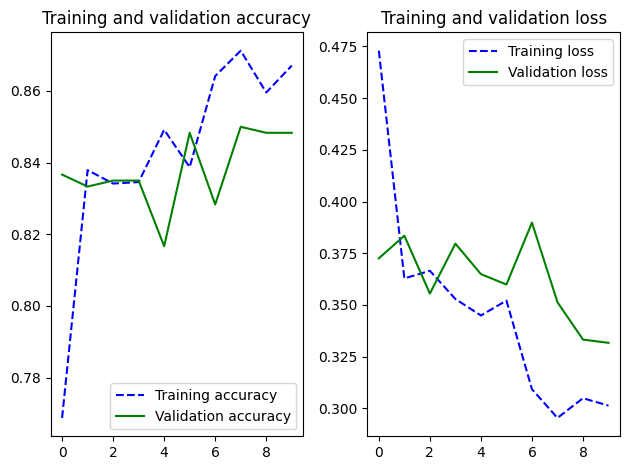

38/38 [==============================] - 4s 113ms/step - loss: 0.3438 - accuracy: 0.8317
Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
------------------------------------------------------------------------
## Training for fold 2/5 ##
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.7758
Epoch 1: val_accuracy improved from -inf to 0.81500, saving model to ./saved_models/model_1.h5
150/150 [==============================] - 23s 144ms/step - loss: 0.4566 - accuracy: 0.7758 - val_loss: 0.4310 - val_accuracy: 0.8150
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8183
Epoch 2: val_accuracy improved from 0.81500 to 0.82667, saving model to ./saved_models/model_1.h5
150/150 [==============================] - 21s 143ms/step - loss: 0.4015 - accuracy: 0.8183 - val_loss: 0.4226 - val_accuracy: 0.8267
Epoch 3/10
150/150 [================

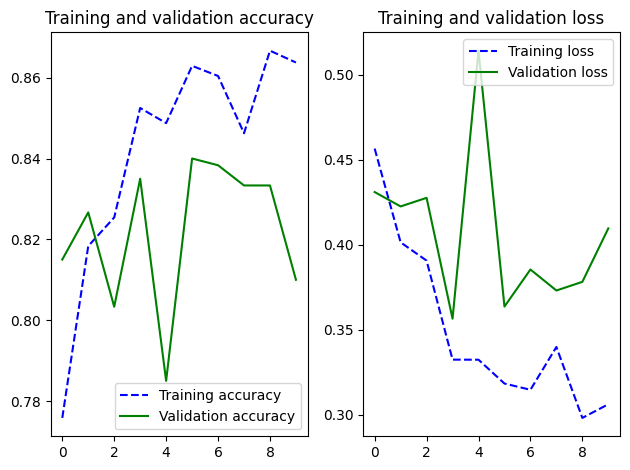

38/38 [==============================] - 5s 132ms/step - loss: 0.3700 - accuracy: 0.8367
Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
------------------------------------------------------------------------
## Training for fold 3/5 ##
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.7575
Epoch 1: val_accuracy improved from -inf to 0.83000, saving model to ./saved_models/model_2.h5
150/150 [==============================] - 24s 151ms/step - loss: 0.4741 - accuracy: 0.7575 - val_loss: 0.3601 - val_accuracy: 0.8300
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8154
Epoch 2: val_accuracy did not improve from 0.83000
150/150 [==============================] - 20s 136ms/step - loss: 0.3940 - accuracy: 0.8154 - val_loss: 0.3828 - val_accuracy: 0.8183
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.3469 - accu

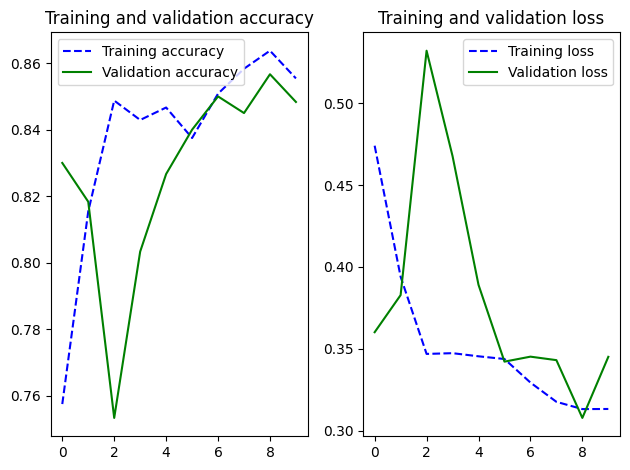

38/38 [==============================] - 5s 120ms/step - loss: 0.3341 - accuracy: 0.8550
Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
------------------------------------------------------------------------
## Training for fold 4/5 ##
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.7746
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to ./saved_models/model_3.h5
150/150 [==============================] - 23s 145ms/step - loss: 0.4710 - accuracy: 0.7746 - val_loss: 0.3780 - val_accuracy: 0.8250
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.8138
Epoch 2: val_accuracy did not improve from 0.82500
150/150 [==============================] - 21s 143ms/step - loss: 0.3875 - accuracy: 0.8138 - val_loss: 0.3941 - val_accuracy: 0.8033
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.3628 - accu

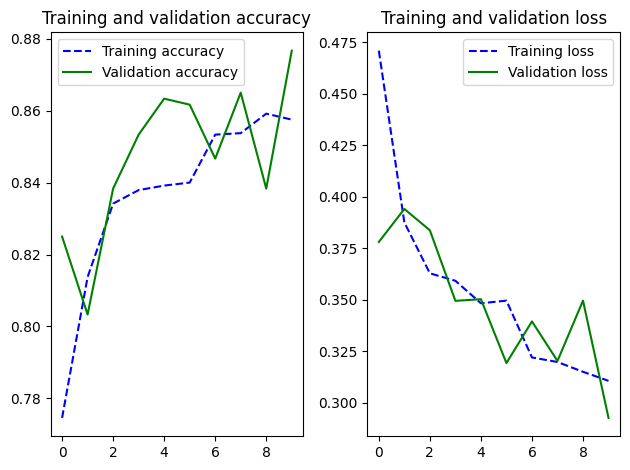

38/38 [==============================] - 4s 104ms/step - loss: 0.2705 - accuracy: 0.8833
Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
------------------------------------------------------------------------
## Training for fold 5/5 ##
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.7604
Epoch 1: val_accuracy improved from -inf to 0.77667, saving model to ./saved_models/model_4.h5
150/150 [==============================] - 79s 144ms/step - loss: 0.4886 - accuracy: 0.7604 - val_loss: 0.4839 - val_accuracy: 0.7767
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8250
Epoch 2: val_accuracy improved from 0.77667 to 0.80000, saving model to ./saved_models/model_4.h5
150/150 [==============================] - 22s 149ms/step - loss: 0.3746 - accuracy: 0.8250 - val_loss: 0.3848 - val_accuracy: 0.8000
Epoch 3/10
150/150 [================

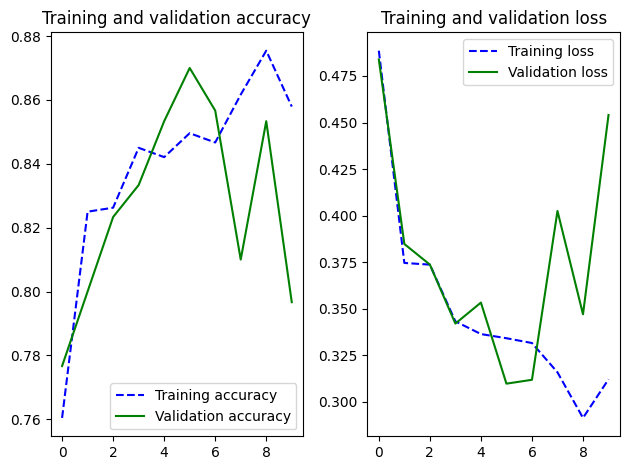

38/38 [==============================] - 5s 127ms/step - loss: 0.3111 - accuracy: 0.8633


In [45]:
# %load solutions/CrossValidation.py

tf.keras.backend.clear_session()

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)
  # A COMPLETER

save_dir = './saved_models/'

for fold_no, (train_index, validation_index) in enumerate(kf.split(np.zeros(len(categories)), categories)):
    train_df = cv_df.iloc[train_index]
    validation_df = cv_df.iloc[validation_index]

    train_generator = train_datagen_augmented.flow_from_dataframe(
        train_df,
        path + 'cv/',
        x_col = 'filename',
        y_col = 'category',
        target_size = (image_size,image_size),
        class_mode = 'binary',
        batch_size = batch_size)

    validation_generator = train_datagen_augmented.flow_from_dataframe(
        validation_df,
        path + 'cv/',
        x_col = 'filename',
        y_col = 'category',
        target_size = (image_size,image_size),
        class_mode = 'binary',
        batch_size = batch_size)

    # CREATE NEW MODEL
    model = create_new_model()

    # COMPILE NEW MODEL
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = optimizers.Adam(learning_rate=3e-4),
        metrics = ['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'## Training for fold {fold_no+1}/{n_folds} ##')

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        save_dir+get_model_name(fold_no),
        monitor = 'val_accuracy',
        verbose = 1,
        save_best_only = True,
        mode = 'max')
    callbacks_list = [checkpoint]

    # FIT THE MODEL
    history = model.fit(
        train_generator,
        epochs = 10,
        callbacks = callbacks_list,
        validation_data = validation_generator)
    # Model weights are saved at the end of every epoch, if it's the best seen so far.

    # PLOT HISTORY
    plot_training_analysis()

    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(save_dir+"model_"+str(fold_no)+".h5")

    results = model.evaluate(validation_generator)
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

##### <i style="color:purple">**Question** : Les performances semblent-elles dépendre du découpage train/val ?</i>

On pourra répondre à cette question à l'aide de boxplot.

In [ ]:
## A COMPLETER ##

[...]

[Ellipsis]

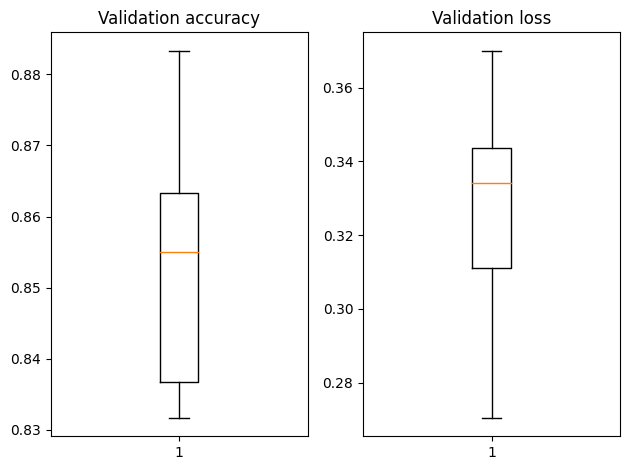

In [46]:
# %load solutions/consistency.py

plt.subplot(1,2,1)
plt.boxplot(VALIDATION_ACCURACY)
plt.title('Validation accuracy')

plt.subplot(1,2,2)
plt.boxplot(VALIDATION_LOSS)
plt.title('Validation loss')

plt.tight_layout()
plt.show()

## Utilisation d'un autre réseau <b style="color:crimson">(pour aller plus loin)</b>

Essayez de charger d'autres modèles que VGG16 au début de ce TP. Vous trouverez sur la doc de Keras [une liste des modèles utilisables](https://keras.io/api/applications/). Vous pouvez par exemple tester des réseaux plus avancés, que vous verrez dans la suite du cours, comme par exemple _Inception_ et _ResNet_. Quel réseau fournit les meilleurs résultats ?

Attention à bien lire la documentation, certains réseaux comme _EfficientNet_ prennent en entrée des images non normalisées, ce qui nécessite des modifications dans l'_ImageDataGenerator_ défini plus haut.

In [47]:
from tensorflow.keras.applications import ResNet50V2

In [48]:
# %load solutions/ResNet_model.py

conv_base = ResNet50V2(
    weights = 'imagenet',
    include_top = False,
    input_shape=(150, 150, 3)
)

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 24,044,161
Non-trainable params: 45,440
_________________________________________________________________


In [49]:
# %load solutions/ResNet_train.py

conv_base.trainable = False

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 50,
    validation_data = validation_generator
)

Epoch 1/50
125/125 [==============================] - 24s 151ms/step - loss: 0.2361 - accuracy: 0.8985 - val_loss: 0.1611 - val_accuracy: 0.9267
Epoch 2/50
125/125 [==============================] - 19s 149ms/step - loss: 0.1796 - accuracy: 0.9230 - val_loss: 0.1529 - val_accuracy: 0.9233
Epoch 3/50
125/125 [==============================] - 17s 137ms/step - loss: 0.1603 - accuracy: 0.9365 - val_loss: 0.1470 - val_accuracy: 0.9367
Epoch 4/50
125/125 [==============================] - 19s 148ms/step - loss: 0.1311 - accuracy: 0.9455 - val_loss: 0.1519 - val_accuracy: 0.9433
Epoch 5/50
125/125 [==============================] - 18s 148ms/step - loss: 0.1210 - accuracy: 0.9485 - val_loss: 0.2016 - val_accuracy: 0.9267
Epoch 6/50
125/125 [==============================] - 18s 148ms/step - loss: 0.1340 - accuracy: 0.9450 - val_loss: 0.0931 - val_accuracy: 0.9550
Epoch 7/50
125/125 [==============================] - 17s 139ms/step - loss: 0.1133 - accuracy: 0.9485 - val_loss: 0.1104 - val_ac

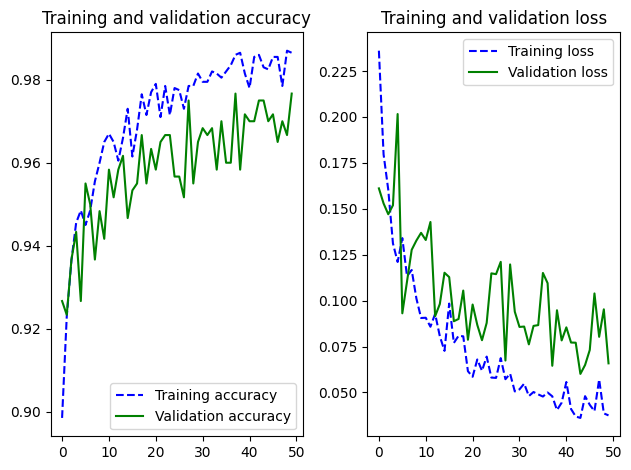

In [50]:
plot_training_analysis()

In [51]:
# %load solutions/ResNet_tune.py

conv_base.trainable = True

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
125/125 [==============================] - 58s 178ms/step - loss: 0.2721 - accuracy: 0.8790 - val_loss: 0.1756 - val_accuracy: 0.9350
Epoch 2/10
125/125 [==============================] - 22s 175ms/step - loss: 0.2035 - accuracy: 0.9075 - val_loss: 0.2361 - val_accuracy: 0.9017
Epoch 3/10
125/125 [==============================] - 20s 160ms/step - loss: 0.1693 - accuracy: 0.9335 - val_loss: 0.1821 - val_accuracy: 0.9333
Epoch 4/10
125/125 [==============================] - 21s 168ms/step - loss: 0.1394 - accuracy: 0.9440 - val_loss: 0.1469 - val_accuracy: 0.9483
Epoch 5/10
125/125 [==============================] - 20s 159ms/step - loss: 0.1305 - accuracy: 0.9490 - val_loss: 0.0954 - val_accuracy: 0.9700
Epoch 6/10
125/125 [==============================] - 21s 167ms/step - loss: 0.1171 - accuracy: 0.9565 - val_loss: 0.1317 - val_accuracy: 0.9550
Epoch 7/10
125/125 [==============================] - 20s 158ms/step - loss: 0.1092 - accuracy: 0.9580 - val_loss: 0.1100 - val_ac

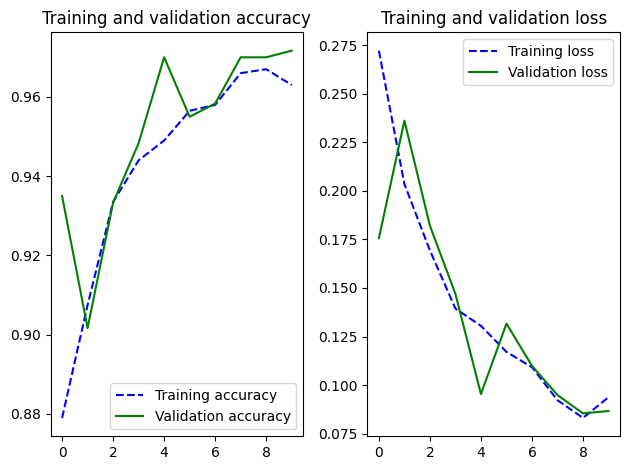

In [52]:
plot_training_analysis()